In [152]:
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import date
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score
import random as rand

sns.set()

In [26]:
def clean_columns(df):
    df.columns = df.columns.map(str.lower)
    df.columns = df.columns.map(lambda x : x.replace('.', '_').replace(' ', '_')) 
    return df

def date_var_plot(df, var, title, y_label):
    df[var].plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Task 1

In [27]:
RISK_FREE_RETURN = 0
ANNUAL_SHARPE_CONSTANT = math.sqrt(252)

In [28]:
df_a = pd.read_csv('futuresA.csv', index_col='Date', date_format='%d/%m/%Y')
df_b = pd.read_csv('futuresB.csv', index_col='Date', date_format='%d/%m/%Y')
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10364 entries, 2018-10-26 to 1977-08-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Last    10237 non-null  float64
dtypes: float64(1)
memory usage: 161.9 KB


In [29]:
class TradingStrategy:
    def __init__(self, dfA, dfB, X, Y, N, L, S, C): 
        assert L > 0 
        assert S < 0

        self._X = X
        self._Y = Y
        self._N = N 
        self._L = L 
        self._S = S 
        self._C = C 

        self.__prep(dfA, dfB)

    def __prep(self, dfA, dfB):

        # Join future B data on future A data.
        self.df = dfA.join(dfB, on=['Date'])
        
        # Clean column names and sort by date.
        self.df = clean_columns(self.df)
        self.dfA = clean_columns(dfA) 

        self.df.sort_index(ascending=True, inplace=True)
        self.dfA.sort_index(ascending=True, inplace=True) 

        # Rename column names to more suitable identifiers.
        self.df.rename(columns={'last' : 'a_last', 'close' : 'b_close'}, inplace=True)

        # Remove NaN entries in joined df so that data exists for both future A and B. 
        self.df.dropna(inplace=True)

        # Rolling std. deviation of future B over window of size N. 
        self.df['b_std_dev_n'] = self.df['b_close'].rolling(self._N).std()

        # Absolute change between each row of futures. 
        self.df['b_change'] = self.df['b_close'].diff().fillna(0)
        self.df['a_change'] = self.df['a_last'].diff().fillna(0)

        # Pct change for each row of future A.
        self.dfA['a_pct_change'] = self.dfA['last'].pct_change()

    def __plot_profit(self):
        date_var_plot(self.df, var='cumulative_profit', title='Trading Strategy Profit', y_label='profit')

    def __plot_drawdown(self):
        date_var_plot(self.df, var='drawdown', title='Trading Strategy Drawdown', y_label='drawdown')

    def __print_stats(self):
        print(f"Annualised return of A: {round(self.__calc_annualised_return() * 100, 3)}%")    
        print(f"Sharpe Ratio of A: {round(self.__calc_sharpe_ratio(), 3)}")
        print(f"Max drawdown (MDD) of strategy: {round(self.__calc_max_drawdown(), 3)}")

    def __calc_max_drawdown(self): 
        return self.df['drawdown'].min() 

    def __calc_sharpe_ratio(self):
        # Sharpe ratio is annualised since returns are worked out daily
        # Use future A original data because times for which future B data was not available was dropped
        return ANNUAL_SHARPE_CONSTANT * ((self.dfA['a_pct_change'].mean() - RISK_FREE_RETURN) / self.dfA['a_pct_change'].std())

    def __calc_annualised_return(self):
        # Annualised return = (1 + cumulative return)^(365 / days held) - 1
        # Days held includes non trading days
        # Cumulative return = (current price - original price) / original price
        cumulative_return = (self.dfA.iloc[-1]['last'] - self.dfA.iloc[0]['last']) / self.dfA.iloc[0]['last']
        days_held = (trade.df.iloc[-1].name - trade.df.iloc[0].name).days
        return (1 + cumulative_return)**(365 / days_held) - 1
        # return ((1 + self.dfA['a_pct_change'].mean())**252)-1

    def __trade(self):
        position = 0
        cumulative = 0
        max_profit = 0
        unrealised_gain = 0

        for i, row in self.df.iterrows():

            delta = 0
            unrealised_gain += position * row['a_change']

            # Long A if B falls by more than X std. deviations in a day.
            if (row['b_change'] < -self._X * row['b_std_dev_n']):
                delta = -position + L 
                position = L

            # Short A if B rises by more than Y std. deviations in a day.
            elif (row['b_change'] > self._Y * row['b_std_dev_n']):
                delta = -position + S 
                position = S 
                
            # Close position of A if neither condition is met.
            else:
                delta = -position 
                position = 0 

            # Drawdown
            drawdown = unrealised_gain / max_profit if max_profit else 0
            self.df.at[i, 'drawdown'] = min(drawdown, 0)

            # If position changed 
            if delta != 0:
                # Profit changes by trading cost and the unrealised gain (which is now realised)
                cumulative += -abs(delta) * self._C + unrealised_gain
                unrealised_gain = 0 
            
            # Max profit must be updated after drawdown is calculated according to definition
            max_profit = max(max_profit, cumulative)

            # Cumulative profit at current time added to dataframe
            self.df.at[i, 'cumulative_profit'] = cumulative 

    def display_corr(self):
        return self.df.corr(numeric_only=True)
    
    def analyse(self):
        self.__trade()
        self.__plot_profit()
        self.__plot_drawdown()
        self.__print_stats()

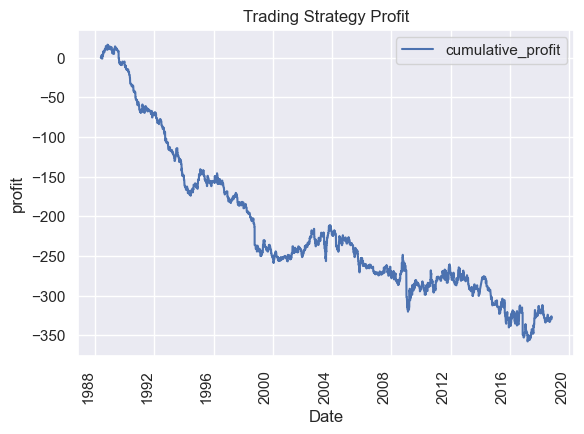

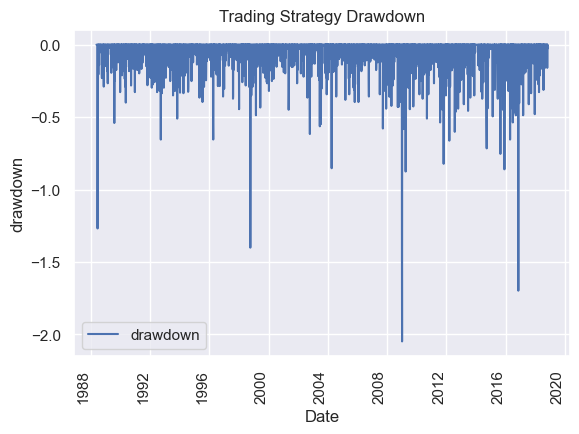

Annualised return of A: 1.021%
Sharpe Ratio of A: 0.123
Max drawdown (MDD) of strategy: -2.048


In [177]:
X = 1.2
Y = 1.5
N = 5
L = 4
S = -3
C = 0.01

trade = TradingStrategy(df_a, df_b, X, Y, N, L, S, C)

trade.analyse()

In [31]:
display(trade.df)

,a_last,b_close,b_std_dev_n,b_change,a_change,drawdown,cumulative_profit
Date,,,,,,,
1988-05-20,85.43750,96.953125,NaN,0.000000,0.00000,0.000000,0.0000
1988-05-23,85.31250,96.796875,NaN,-0.156250,-0.12500,0.000000,0.0000
1988-05-24,85.46880,96.812500,NaN,0.015625,0.15630,0.000000,0.0000
1988-05-25,85.75000,96.890625,NaN,0.078125,0.28120,0.000000,0.0000
1988-05-26,85.65620,96.765625,0.076547,-0.125000,-0.09380,0.000000,-0.0400
...,...,...,...,...,...,...,...
2018-10-22,137.68750,112.085938,0.070659,0.023438,-0.12500,-0.030449,-326.5537
2018-10-23,138.18750,112.265625,0.083889,0.179688,0.50000,0.000000,-326.5837
2018-10-24,139.06250,112.484375,0.169821,0.218750,0.87500,-0.159859,-329.2387


# Task 2

We first look at some edge cases:
- When p1 = p2 = 0, we are not forced into any trades and can proceed as normal. 
- If p1 = p2 = 1, we are forced into both positions with a final position of 0, giving us 2S x $M gain every timestep. When M > 0, this is guaranteed profit. When M = 0, we proceed as normal. When M < 0, we consider this a regular trading/upkeep fee, i.e., we incur 2S x $M loss every timestep and therefore the strategy needs to be more profitable.  
- We assume C < 0, since we should not be payed to make voluntary trades; in the case of M >= C >= 0, for example, we would be able to revert the forced position and make profit or break even every timestep. 
- When S = 0, we are never forced into any position and so don't get payed; we can proceed as normal. When S < 0, we can treat S > 0 and switch p1 and p2. So always S > 0 without loss of generality.
- When M = 0, we are forced into positions without any benefit. When M < 0, we are forced into positions and pay to do so. In a real scenario, there little benefit to do this unless the market maker also gets more control over the bid-ask spread. 
- If p1, p2 << 1, it's unlikely we get to position > L and therefore it's unlikely we need to incur trading costs of manually closing contracts. The same goes for when L >> S. 

Therefore, I would propose running some simulations with the following conditions:
- 0 <= p1, p2 <= 1 
- C > 0 
- S > 0 
- L > 0
- L >= S (otherwise we must sell of part of the position we were forced into every time)
- Any M
- C > M (reduces trivial cases)

## Simulation and Decision Tree

In [178]:
MAX_TIMESTEPS = 100

class Simulation:
    def __init__(self, p1, p2, S, M, C, L, indep=True):
        assert 0 <= p1 <= 1
        assert 0 <= p2 <= 1 
        assert L > 0
        assert S > 0

        self.p1 = p1
        self.p2 = p2 
        self.S = S
        self.payout = M * S 
        self.C = C 
        self.L = L 
        self.cumulative = 0
        self.pos = 0
        self.indep = indep

    def trade(self):

        for i in range(0, MAX_TIMESTEPS):

            # Randomly entered into long
            if (rand.random() <= p1):
                self.pos += self.S 
                self.cumulative += self.payout

            # Randomly entered into short (independent of p1)
            if (self.indep and rand.random() <= p2):
                self.pos -= S 
                self.cumulative += self.payout

            # Can manage risk after market making activities have been done
            risk_delta = self.risk_strategy()
            self.pos += risk_delta 
            self.cumulative -= abs(risk_delta) * self.C

            # If open position > L after risk management, must close [pos - L] contracts
            if abs(self.pos) > self.L:
                delta = self.L - self.pos if self.pos > 0 else -(self.pos + L)
                self.pos += delta 
                self.cumulative -= abs(delta) * self.C

        return self.cumulative

    # Return the number to sell or buy to manage risk
    def risk_strategy(self):
        return 0

The below code fills in a dataframe with results from running the simulation with varying parameters. In this case, no extra risk management strategy was added, but this process could easily be generalized by adding it to the class and generating more test data.

 Using nested for loops is very inefficient and doesn't generate the whole range of data (this is how the current test data is generated). If I had to do this again, I would use some kind of random or stochastic process to generate data because sparse data, or at least non-uniform data, can be just as efficient at training a classification model. Furthermore, the same parameters could result in different profits so it would be beneficial to run a simulation multiple times and then take the average profit of every run, or run similar 'clusters' of parameters to reduce the volatility of the probabilities. 
 
In this instance, a boolean 'is_profitable' was used rather than profit value because the task is only to determine what kinds of parameters make the model profitable. If looking for which parameters generated greater amounts of profit, a regression decision tree would be used instead. 

In [201]:
# sim_df = pd.DataFrame(columns=['p1', 'p2', 'S', 'M', 'C', 'L', 'is_profitable'])

## Original for loop used to generate the current data
# for p1 in np.arange(0, 1, 0.05):
#     for p2 in np.arange(0, 1, 0.05):
#         for S in range(1, 3):
#             for L in range(1, 7):
#                 for M in np.arange(-2, 2, 0.1):
#                     for C in np.arange(M, 2, 0.1):
#                         sim = Simulation(p1, p2, S, M, C, L)
#                         sim_df.loc[len(sim_df)] = {'p1' : p1, 'p2' : p2, 'S' : S, 'M' : M, 'C' : C, 'L' : L, 'is_profitable' : int(sim.trade() > 0)}

## New randomised process to generate wider variety of data
# def simulator(max_samples=500000, s_range=10, l_range=15, m_range=3, c_range=5):
#     sim_df = pd.DataFrame(columns=['p1', 'p2', 'S', 'M', 'C', 'L', 'is_profitable'])

#     for i in range(max_samples):
#         p1 = rand.random()
#         p2 = rand.random()
#         S = rand.randint(1, s_range)
#         L = rand.ranint(S, l_range)
#         M = round(rand.uniform(-m_range, m_range), 2)
#         C = round(rand.uniform(0, c_range), 2)

#         sim = Simulation(p1, p2, S, M, C, L)
#         sim_df.loc[len(sim_df)] = {'p1' : p1, 'p2' : p2, 'S' : S, 'M' : M, 'C' : C, 'L' : L, 'is_profitable' : int(sim.trade() > 0)}

#     return sim_df

In [225]:
sim_df

,p1,p2,S,M,C,L,is_profitable
0,0.00,0.00,1,-2.0,-2.000000e+00,1,0
1,0.00,0.00,1,-2.0,-1.900000e+00,1,0
2,0.00,0.00,1,-2.0,-1.800000e+00,1,0
3,0.00,0.00,1,-2.0,-1.700000e+00,1,0
4,0.00,0.00,1,-2.0,-1.600000e+00,1,0
...,...,...,...,...,...,...,...
723006,0.15,0.65,1,-0.2,1.700000e+00,6,0
723007,0.15,0.65,1,-0.2,1.800000e+00,6,0
723008,0.15,0.65,1,-0.2,1.900000e+00,6,0
723009,0.15,0.65,1,-0.1,-1.000000e-01,6,0


The idea is to use classification to make predictions about which sets of parameters lead to profitable results. Using a decision tree is especially helpful because it can be plotted to show what conditions it's using to make its decision. This is more useful than other classification methods which tend to result in a black box approach. Also, decision trees tend to deal with outliers in the data better. 

The data is split into testing and training for cross-validation so the model isn't overfitted. Of course, the wider variety of data we get the better, as it would increase the prediction accuracy. 

In the plot below, orange is not profitable and blue profitable (closer to white when samples are split). Note: left is true and right is false. The figure is hard to read on the notebook so I saved it as a .svg to zoom in on the results. In addition, the max tree depth is restricted here to make it easier to read and graph, but ideally the data samples would be more diverse and the tree depth could be set higher to find more precise boundaries for where parameters have the greatest effect. 

In [182]:
X = sim_df.drop(columns=['is_profitable'])
y = sim_df['is_profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [228]:
MAX_TREE_DEPTH = 7
dtree = DecisionTreeClassifier(random_state=42, max_depth=MAX_TREE_DEPTH)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print(f"F1-Score: {f1_score(y_pred=y_pred, y_true=y_test)}")

F1-Score: 0.956597380433612


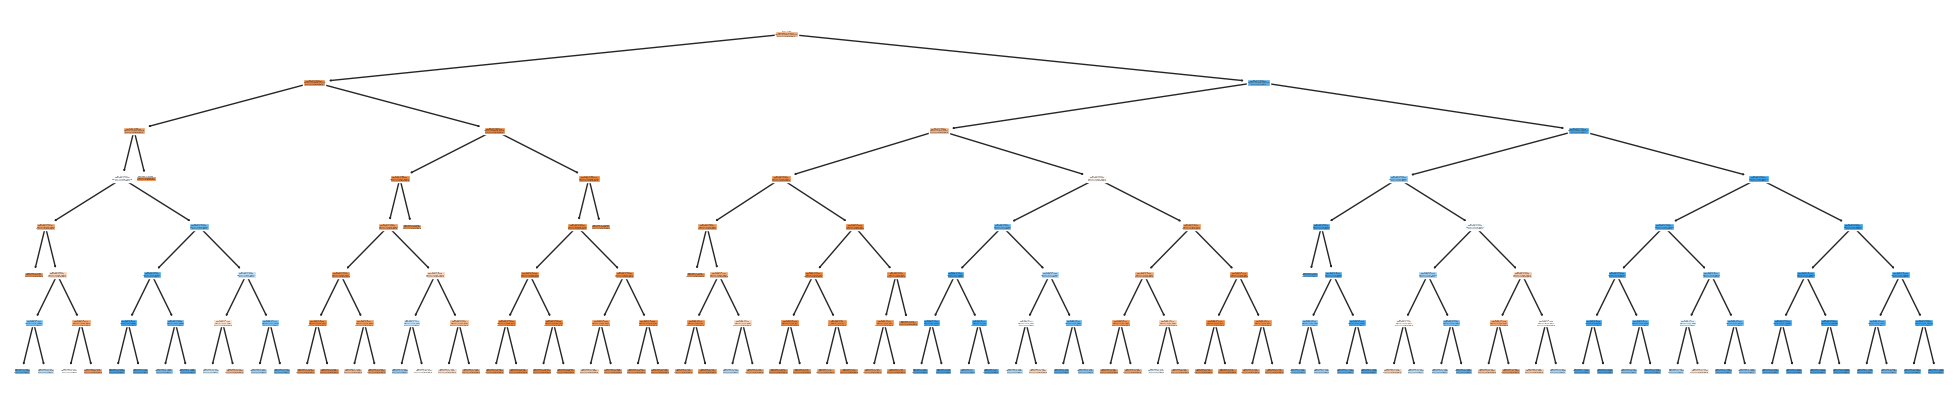

In [230]:
plt.figure(figsize=(25,5))
tree = plot_tree(dtree, feature_names=['p1', 'p2', 'S', 'M', 'C', 'L'], class_names=['not profitable', 'profitable'], impurity=False, filled=True)
plt.savefig('tree.svg')
plt.show()

I will now outline some of the results from the decision tree, and some of the limitations of this method. 
- More profitable simulations occurred when M > -0.05. This is intuitive because the more we get payed to be forced into the market, the more profit we are likely to make.
- Notably, there were some instances when M <= 0 and the simulation was profitable. These tended to be when p1 and p2 were low. 
  - For example, M <= -0.05, 0.025 < p1 <= 0.075, p2 <= 0.025, M <= C <= 0.05. In this case, L <= 3.5 was a good predictor of profitability. On the other hand, if p2 > 0.025, then L <= 1.5 was a decent predictor (around 60% confidence).
  - Indeed, many profitable simulations were possible only because C was negative (i.e., we get payed to make voluntary trades) which generally doesn't happen, although it did still satisfy the condition C > M. In the new simulator, The condition C > 0 is set to be more pragmatic. 
- When M >= -0.05, close to 90% of the simulation were profitable. 
  - Low p2 was generally unprofitable unless p1 was also low. Although there were cases with low p2, high p1, high L, and low S that were profitable.  
  - Even when both p1 and p2 were low, a high S could lead to unprofitability.
  
In conclusion, here we have considered the simplest scenario (no market change, independent p1 and p2, no extra risk management strategy). The most successful strategies were those that either reduced the chance to be forced into the market, had higher gains when being forced into the market, or didn't have to incur the trading costs of managing risk as often: 
- Had a high M 
- Had a low C 
- Had low p1 and/or p2 
- Had a low S relative to a high L

The next steps would be to implement a risk management strategy (can easily be done with function provided), to simulate when p2 is dependant on p1, and to use some market data to simulate change in value (which could be used to implement a risk management strategy). 

The problem could also be solved analytically to get a formula for the expected value after a certain number of timesteps. However, this approach faces two problems: firstly, the formula would be different for every risk management strategy; secondly, finding the formula is non-trivial and would likely take longer than generating new data and training a model. Although the model can be occasionally incorrect, the simulation route is generally better because it is more scalable as different risk management strategies can be tested.